In [1]:
import numpy as np
import scipy
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
import corner
from emcee import EnsembleSampler

In [2]:
### change matplotlib default fontsize & such ###
mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Helvetica Neue') 
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 16})

In [3]:
### linear model of y-x relation ###
def predict_y(x, theta):
    return theta[0] + theta[1] * x

### define skew normal distribution ###
def skew_normal(x, center=0., width=1., skewness=-5.):
    """
    Returns skew normal pdf at points x.
    """
    
    t = (x - center) / width
    return 2 / width * stats.norm.pdf(t) * stats.norm.cdf(skewness * t)

def log_skew_normal(x, center=0., width=1., skewness=5.):
    """
    Returns skew normal pdf at points x.
    """
    
    t = (x - center) / width
    tmp = -np.log(width) - t**2 / 2 + np.log(stats.norm.cdf(skewness * t))
    if (np.isnan(tmp) or np.isinf(tmp)):
        return -1e5
    else:
        return tmp

# Use a skew normal distribution for the distribution of the measurements #

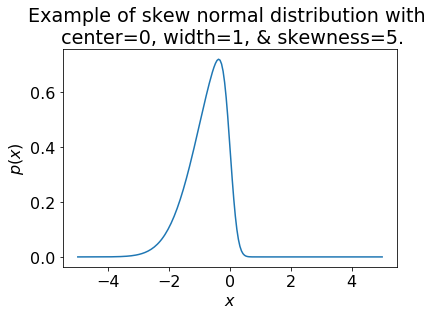

Integral of pdf = 1.0000


In [4]:
### plot skew normal distribution ###
span = np.linspace(-5., 5., 200)
p = skew_normal(span)

fig, ax = plt.subplots()
ax.plot(span, p)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p(x)$')
ax.set_title('Example of skew normal distribution with \n center=0, width=1, & skewness=5.')

plt.show()
print(f'Integral of pdf = {np.trapz(p, span):.4f}')

In [5]:
### generate example distributions for N data points ###
N = 6
x_vec = np.linspace(0., 10., N)

np.random.seed(42)
widths = 2. * np.random.rand(N) + 0.5
skewnesses = 10.0 * (np.random.rand(N) - 0.5)
theta_true = [2.2, 1.5]
centers = predict_y(x_vec, theta_true) + 0.2 * (0.5 - np.random.rand(N)) # y = kx + m + error

y_dists = [lambda t, center=c, width=w, skewness=s : skew_normal(t, center=center, width=width, skewness=skewness)
           for c, w, s in zip(centers, widths, skewnesses)] # list of y distributions

# Plot measurement distributions along w/ the true relation #

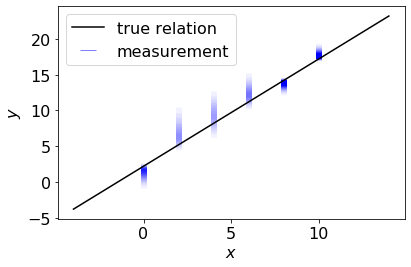

In [6]:
### plot true line ###
t = np.linspace(x_vec.min() - 4., x_vec.max() + 4., N)
y_true = predict_y(t, theta_true)
fig, ax = plt.subplots()
ax.plot(t, y_true, label=r'true relation', color='k')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

### bodgily use alpha to plot distributions ###
x_list = []
y_list = []
for x, y_dist in zip(x_vec, y_dists):
    y_true = predict_y(x, theta_true)
    for y in np.linspace(y_true - 10., y_true + 10., 1000):
        for _ in range(int(30 * y_dist(y))):
            x_list.append(x)
            y_list.append(y)
ax.scatter(x_list, y_list, marker='_', color='b', alpha=0.002)
artist = plt.Line2D((0,1),(0,0), color='b', marker='_', markersize=16, linestyle='', alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles + [artist], labels + ['measurement'])
plt.tight_layout()
plt.show()

# Fit the model y = kx + m + error #
The likelihood is now calculated from y = kx + m + error where the the errors are these distributions but centered around 0.

In [7]:
### define pdf:s ###
def prior(theta):
    return 1. # flat prior, not normalized

def likelihood(theta):
    
    centers = predict_y(x_vec, theta) # we now instead think of the distribution as centered at y=kx+m
    likelihoods = [] #initiate
    for y, center, width, skewness in zip(y_vec, centers, widths, skewnesses):        
        y_dist = lambda t : skew_normal(t, center=center, width=width, skewness=skewness)
        likelihoods.append(y_dist(y))

    return np.prod(likelihoods)

def posterior(theta):
    return prior(theta) * likelihood(theta)

In [8]:
### define log pdf:s ###
def log_prior(theta):
    return 0.

def log_likelihood(theta):
    
    centers = predict_y(x_vec, theta) # we now instead think of the distribution centered at y=kx+m
    likelihoods = [] #initiate
    for y, center, width, skewness in zip(y_vec, centers, widths, skewnesses):        
        y_dist = lambda t : log_skew_normal(t, center=center, width=width, skewness=skewness)
        likelihoods.append(y_dist(y))

    return np.sum(likelihoods)

def log_posterior(theta):
    return log_prior(theta) + log_likelihood(theta)

In [9]:
### redefine measurements as their expected value ###
y_vec = np.empty(x_vec.shape) # initiate
for i, x in enumerate(x_vec):
    t = np.linspace(-20., 20., 800)
    y_mean = np.trapz(t * y_dists[i](t), t)
    y_vec[i] = (y_mean)
y_vec = np.array(y_vec)

In [ ]:
dim = 2
nbr_bins = 31
nbr_walkers = 32
nbr_warmup = 200
nbr_samples = 2000
    
### define MCMC sampler ###
initial_positions = 1. * np.random.rand(nbr_walkers, dim)
sampler = EnsembleSampler(nbr_walkers, dim, log_posterior)

### run sampler ###
pos, _, _ = sampler.run_mcmc(initial_positions, nbr_warmup)
sampler.reset()
sampler.run_mcmc(pos, nbr_samples);
samples = sampler.flatchain

### make histogram corner plot ###
latex_labels = [r"$\theta_0$", r"$\theta_1$"]
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], bins = nbr_bins,
                       show_titles=True, title_kwargs={"fontsize": 19}, labels=latex_labels)
plt.show()

/home/simon/miniconda3/envs/tif285-env/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


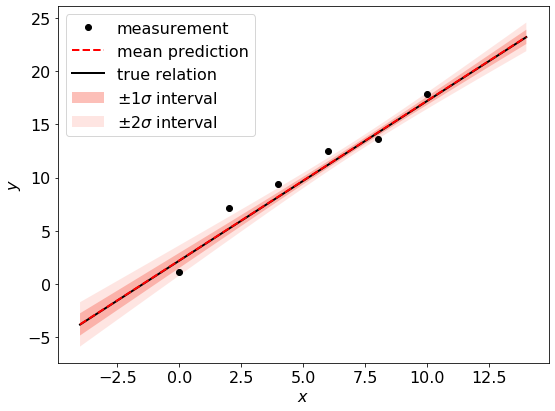

In [11]:
### fit curve ###
N = 200
t = np.linspace(x_vec.min() - 4., x_vec.max() + 4., N)
y = np.empty((nbr_walkers * nbr_samples, N)) # initiate
for i in range(nbr_walkers * nbr_samples):
    y[i,:] = predict_y(t, samples[i,:])

y_mean = y.mean(axis = 0)
y_variance = np.sqrt(y.var(axis = 0))

### plot fitted curve ###
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(x_vec, y_vec, 'o', color='black', label=r'measurement', zorder=3)
ax.plot(t, y_mean, "--", linewidth=2, color='red', label="mean prediction", zorder=2)
ax.plot(t, predict_y(t, theta_true), "-", linewidth=2, color='k', label="true relation", zorder=1)
ax.fill_between(t, y_mean - 1. * y_variance, y_mean + 1. * y_variance, facecolor="salmon", alpha=0.5, label=r'$\pm 1 \sigma$ interval') # 68% DOB interval
ax.fill_between(t, y_mean - 2. * y_variance, y_mean + 2. * y_variance, facecolor="salmon", alpha=0.2, label=r'$\pm 2 \sigma$ interval') # 68% DOB interval
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

plt.legend()
plt.tight_layout()
plt.show()